In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, recall_score, roc_curve, precision_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import re
from mlxtend.plotting import plot_confusion_matrix


# Data preprocess

In [2]:
data = pd.read_csv("/kaggle/input/android-malware-dataset-for-machine-learning/drebin-215-dataset-5560malware-9476-benign.csv",  encoding="utf-8", low_memory=False, na_values="?")
data.dropna(inplace=True)

print("Total missing values : ",sum(list(data.isna().sum())))

Total missing values :  0


In [3]:
ledger = pd.read_csv("/kaggle/input/android-malware-dataset-for-machine-learning/dataset-features-categories.csv",  encoding="utf-8", low_memory=False, na_values="?")
ledger

,transact,API call signature
0,onServiceConnected,API call signature
1,bindService,API call signature
2,attachInterface,API call signature
3,ServiceConnection,API call signature
4,android.os.Binder,API call signature
...,...,...
210,ACCESS_FINE_LOCATION,Manifest Permission
211,SET_WALLPAPER_HINTS,Manifest Permission
212,SET_PREFERRED_APPLICATIONS,Manifest Permission
213,WRITE_SECURE_SETTINGS,Manifest Permission


In [4]:
from sklearn.preprocessing import LabelEncoder

classes,count = np.unique(data['class'],return_counts=True)
label_encoder = LabelEncoder()
data = data.replace(classes,label_encoder.fit_transform(classes))
data = data.apply(pd.to_numeric, errors='coerce')
data.dtypes

transact                      int64
onServiceConnected            int64
bindService                   int64
attachInterface               int64
ServiceConnection             int64
                              ...  
ACCESS_FINE_LOCATION          int64
SET_WALLPAPER_HINTS           int64
SET_PREFERRED_APPLICATIONS    int64
WRITE_SECURE_SETTINGS         int64
class                         int64
Length: 216, dtype: object

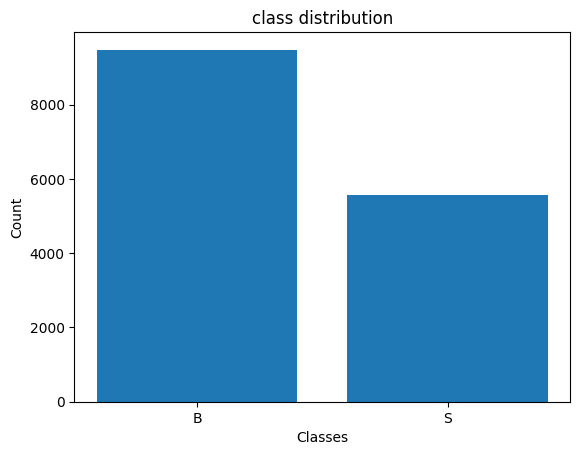

In [5]:
# class distribution

plt.bar(classes, count)
plt.title("class distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

# Dataset prep and Analysis

In [6]:
from sklearn.utils import resample

class_counts = data["class"].value_counts()
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

minority_samples = data[data["class"] == minority_class]
majority_samples = data[data["class"] == majority_class]
minority_oversampled = resample(minority_samples,
                                 replace=True,      # Sample with replacement
                                 n_samples=len(majority_samples),  # Match majority class
                                 random_state=0)

balanced_data  = pd.concat([majority_samples, minority_oversampled])
balanced_data = balanced_data.sample(frac=1, random_state=0)


In [7]:
from sklearn.model_selection import train_test_split 
train_x,test_x,train_y,test_y = train_test_split(data[data.columns[:len(data.columns)-1]].to_numpy(),
                                                 data[data.columns[-1]].to_numpy(),
                                                  test_size = 0.2,
                                                  shuffle=True)

In [8]:
train_y = train_y.reshape((-1,1))
test_y = test_y.reshape((-1,1))

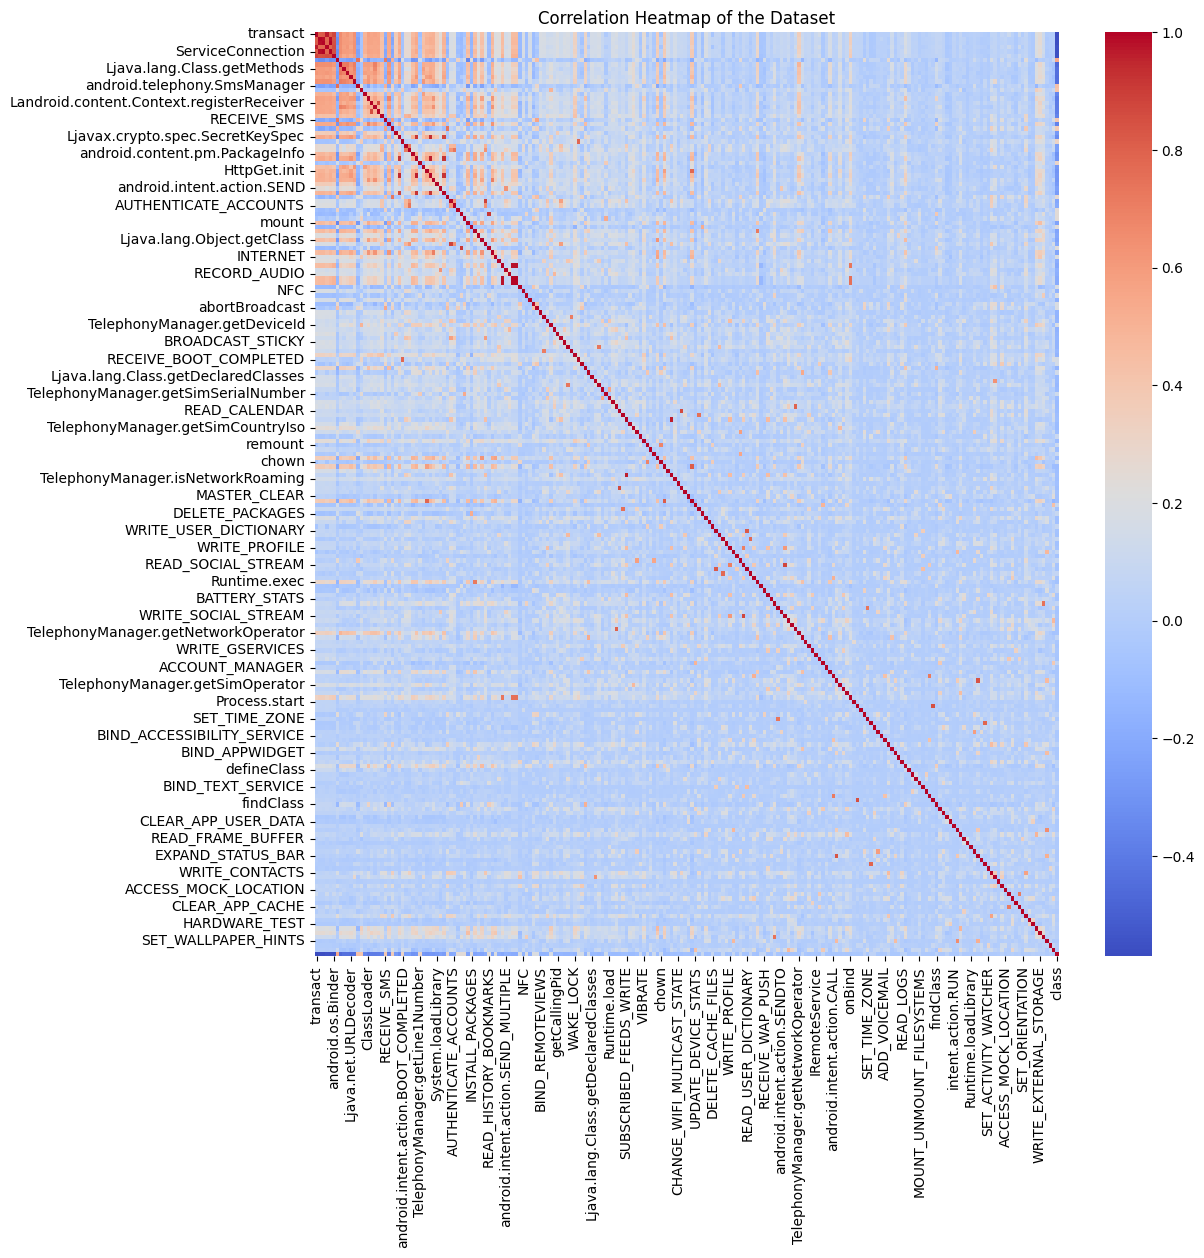

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(data.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of the Dataset")
plt.show()

Text(0.5, 1.0, 'Mutual Information Heatmap')

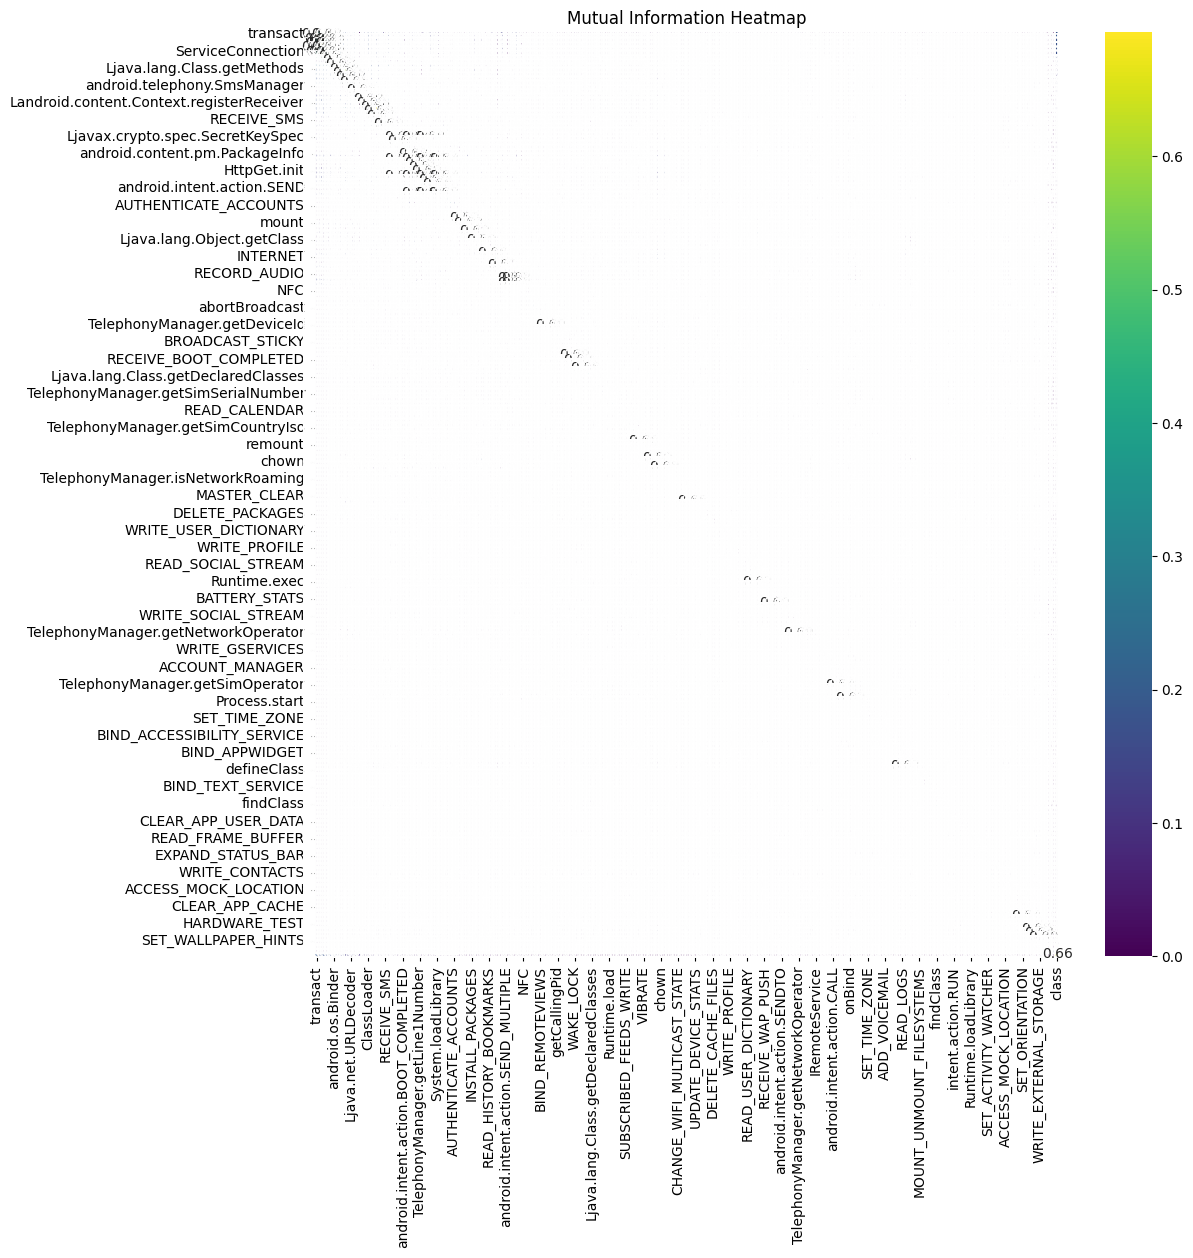

In [10]:
from sklearn.metrics import mutual_info_score

def calculate_mi_matrix(df):
    df = df.copy()
    n = len(df.columns)
    mi_matrix = pd.DataFrame(np.zeros((n, n)), index=df.columns, columns=df.columns)

    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            mi = mutual_info_score(df.iloc[:, i], df.iloc[:, j])
            mi_matrix.iloc[i, j] = mi

    return mi_matrix

mi_matrix = calculate_mi_matrix(data)

plt.figure(figsize=(12,12))
sns.heatmap(
    mi_matrix,        # The data to plot
    annot=True,       # Display the numeric value in each cell
    cmap='viridis',   # The color map to use
    fmt=".2f"         # Format the numbers to two decimal places
)
plt.title('Mutual Information Heatmap')

            


# Logistic Regression

In [11]:
logreg = LogisticRegression()
start = time.time()
logreg.fit(train_x, train_y)
end = time.time()
logreg_time = end - start
print("Logistic Regression Train Time:", logreg_time)


Logistic Regression Train Time: 0.683605432510376


In [12]:
train_pred = logreg.predict(train_x)
test_pred = logreg.predict(test_x)

logres_train_accuracy = accuracy_score(train_y, train_pred)
logres_test_accuracy = accuracy_score(test_pred, test_y)

In [13]:
print(classification_report(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1901
           1       0.98      0.97      0.98      1106

    accuracy                           0.98      3007
   macro avg       0.98      0.98      0.98      3007
weighted avg       0.98      0.98      0.98      3007



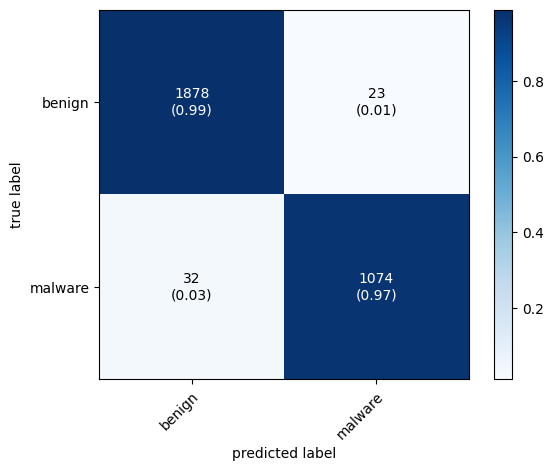

In [14]:
lg_conf_matrix = confusion_matrix(test_y, test_pred)
fig, ax = plot_confusion_matrix(conf_mat=lg_conf_matrix, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
plt.show()